## 照例先检查GPU

In [9]:
!nvidia-smi

Fri Dec 15 13:41:53 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 378.13                 Driver Version: 378.13                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Graphics Device     Off  | 0000:02:00.0     Off |                  N/A |
| 23%   26C    P0    56W / 250W |      0MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Graphics Device     Off  | 0000:03:00.0     Off |                  N/A |
|  0%   23C    P0    55W / 250W |      0MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

## 导入常用库

In [8]:
import matplotlib.pyplot as plt
import openslide
from openslide import OpenSlide
import cv2
import numpy as np
import tensorflow as tf
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using TensorFlow backend.


## 导入图片
image事实上是PIL的封装，大小固定为vgg16的224*224
copy from https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py
```

def load_img(path, grayscale=False, target_size=None, interpolation='nearest')
try:
    from PIL import Image as pil_image
except ImportError:
    pil_image = None
    
if target_size is not None:
    width_height_tuple = (target_size[1], target_size[0])
    if img.size != width_height_tuple:
        if interpolation not in _PIL_INTERPOLATION_METHODS:
            raise ValueError(
                'Invalid interpolation method {} specified. Supported '
                'methods are {}'.format(
                    interpolation,
                    ", ".join(_PIL_INTERPOLATION_METHODS.keys())))
        resample = _PIL_INTERPOLATION_METHODS[interpolation]
        img = img.resize(width_height_tuple, resample)
return img

```

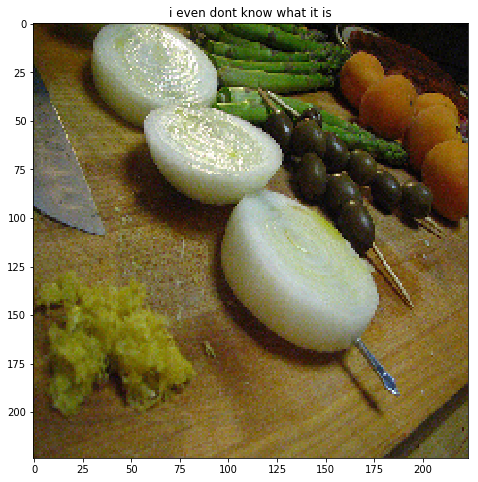

In [39]:
from keras.preprocessing import image
img_path = 'apricot_565.jpeg'
# img_path = 'Elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))

plt.imshow(img);
plt.title('i even dont know what it is');

## 预处理
做了去中心化处理，但是没有归一化
copy from https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py
```
x = x[..., ::-1]
# Zero-center by mean pixel
x[..., 0] -= 103.939
x[..., 1] -= 116.779
x[..., 2] -= 123.68
```

In [19]:
from keras.applications.vgg16 import preprocess_input
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x.shape
print(x[:,0:3,:,:])

(1, 224, 224, 3)

[[[[-100.93900299  -82.77899933  -66.68000031]
   [-103.93900299  -82.77899933  -65.68000031]
   [ -92.93900299  -79.77899933  -62.68000031]
   ..., 
   [ -96.93900299 -111.77899933 -118.68000031]
   [ -95.93900299 -110.77899933 -118.68000031]
   [ -99.93900299 -108.77899933 -120.68000031]]

  [[ -89.93900299  -72.77899933  -60.68000031]
   [ -98.93900299  -62.77899933  -47.68000031]
   [ -92.93900299  -77.77899933  -73.68000031]
   ..., 
   [ -94.93900299 -112.77899933 -120.68000031]
   [ -94.93900299 -112.77899933 -118.68000031]
   [ -98.93900299 -111.77899933 -118.68000031]]

  [[ -98.93900299  -61.77899933  -68.68000031]
   [ -96.93900299  -78.77899933  -54.68000031]
   [ -93.93900299  -69.77899933  -56.68000031]
   ..., 
   [-100.93900299 -106.77899933 -116.68000031]
   [ -92.93900299 -107.77899933 -115.68000031]
   [ -96.93900299 -111.77899933 -119.68000031]]]]


## 加载vgg16模型

In [20]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=True, weights='imagenet')

In [41]:
model.summary()
# VGG16	528MB	0.715	0.901	138,357,544	23

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## 预测

In [21]:
scores = model.predict(x)

In [23]:
# 应该有1000个值
print(scores.shape)
# 找最大的
print(np.argmax(scores))

(1, 1000)
943


In [28]:
# 数字对应的类别文件存在了.keras/models/imagenet_class_index.json
from keras.applications.vgg16 import decode_predictions
print('Predicted:', decode_predictions(scores, top=3)[0])
# 看结果得分都不高

('Predicted:', [(u'n07718472', u'cucumber', 0.37633196), (u'n07716358', u'zucchini', 0.25885594), (u'n07711569', u'mashed_potato', 0.049367212)])


In [40]:
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions

img_path = './Elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
img = image.load_img(img_path, target_size=(224, 224))
model = VGG16(include_top=True, weights='imagenet')
scores = model.predict(x)
print('Predicted:', decode_predictions(scores, top=3)[0])

('Predicted:', [(u'n02504458', u'African_elephant', 0.7796343), (u'n01871265', u'tusker', 0.19836973), (u'n02504013', u'Indian_elephant', 0.021544486)])


In [42]:
del model